## SME0130 - Redes Complexas

Projeto Prático: Classificação de redes

Professor: Francisco Aparecido Rodrigues, francisco@icmc.usp.br. <br>
Estudantes: 
 * Bruno F. Bessa (num. 5881890), bruno.fernandes.oliveira@usp.br <br>
 * Daniel Torkomian Joaquim (num. ??), ???@usp.br <br>

Universidade de São Paulo, São Carlos, Brasil.

Selecione 3 redes biológicas, 3 redes sociais e 3 redes tecnológicas desses endereços:

 * https://networks.skewed.de 
 * http://konect.cc/networks/ 
 * https://icon.colorado.edu/

Faça a classificação das redes usando os modelos e medidas que aprendemos na aula. Não se esqueça de selecionar o mesmo N e grau médio que a rede original na construção dos modelos.

Verifique qual o modelo mais adequado para cada rede.

<b>Hipótese: redes do mesmo tipo seguem o mesmo modelo.</b>

Verifique se essa hipótese é verdadeira.
Bônus (não é obrigatório): identifique as principais diferenças entre os modelos. Isto é, quais medidas mais contribuem para que uma rede seja classificada como sendo do modelo BA.

## Metodologia

Para o desenvolvimento do projeto prático selecionamos as redes abaixo conforme a indcação:

Social:
 * Terrorists: https://networks.skewed.de/net/terrorists_911#None_draw
 * Windsurfers: http://konect.cc/networks/moreno_beach/
 * Karate: http://konect.cc/networks/ucidata-zachary/
 
Biological:
 * Zebra: http://konect.cc/networks/moreno_zebra/
 * Sheep: http://konect.cc/networks/moreno_sheep/
 * HIV: http://konect.cc/networks/hiv/
 
Technological:
 * Unicode: http://konect.cc/networks/unicodelang/
 * Facebook: http://konect.cc/networks/ego-facebook/
 * Air Traffic: http://konect.cc/networks/maayan-faa/
 
Para cada uma destas redes foi treinada gerada uma coleção de redes sintéticas das seguintes topologias:
 * Erdos-Renyi
 * Watts-Strogatz
 * Barabási-Albert
 * Waxman
 * Geométrica
 
sendo o grau médio da rede a ser classificada um parâmetro passado para o ajuste na criação das redes sintéticas.

A função <b>measures</b> calcula para uma rede as seguintes medidas que serão usadas para o cálculo das distâncias no classificador KNN:
 * k1: primeiro momento do grau
 * k2: segundo momento do grau
 * variance: variância do grau
 * av_cl: coeficiente de clustering médio
 * l: caminho mínimo médio
 * r: coeficiente de assortatividade
 * Cx: coeficiente de complexidade
 * CC: coeficiente de transitividade
 * av_EC: eigenvector-ccentrality médio
 * Mod: modularidade
 * H: entropia de Shannon do grau
 
Após a carga das redes (em arquivos de texto) pela função <b>get_graph_from_data_file</b>, utilizamos as funções <b>train_model</b> e <b>test_model</b> (a primeira é invocada por meio da segunda) para geração do algoritmo classificados KNN e produzir a classificação desejada.

Os resultados foram os seguintes:

Redes sociais:
 * Terrorists: Barabási-Albert
 * Windsurfers: Barabási-Albert
 * Karate: Barabási-Albert
 
Biological:
 * Zebra: Geométrica
 * Sheep: Barabási-Albert
 * HIV: Barabási-Albert
 
Technological:
 * Unicode: Watts-Strogatz
 * Facebook: Barabási-Albert
 * Air Traffic: Barabási-Albert
 
De modo que não se verificou a hipótese de que redes do memso tipo seguem a mesma topologia.

## Código

Os códigos utilizados para a geração dos resultados consam abaixo.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms.community import greedy_modularity_communities
import math
from scipy.stats import pearsonr
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
def measures(G):
    def momment_of_degree_distribution(G,m):
        M = 0
        N = len(G)
        for i in G.nodes:
            M = M + G.degree(i)**m
        M = M/N
        return M

    N = len(G)
    M = G.number_of_edges()
    vk = dict(G.degree())
    vk = list(vk.values())
    vk = np.array(vk)


    def degree_distribution_Pk(G):
        maxk = np.max(vk) #valor máximo
        mink = np.min(vk) #valor mínimo
        kvalues= np.arange(0,maxk+1) # valores possíveis de k
        Pk = np.zeros(maxk+1) # P(k)
        for k in vk:
            Pk[k] = Pk[k] + 1
        Pk = Pk/sum(Pk) # Normalizando
        return kvalues,Pk

    k, Pk = degree_distribution_Pk(G)

    def shannon_entropy(G):
        k,Pk = degree_distribution_Pk(G)
        H = 0
        for p in Pk:
            if(p > 0):
                H = H - p*math.log(p, 2)
        return H


    c = list(greedy_modularity_communities(G))
    communities = np.zeros(len(G.nodes()))
    nc = 0
    for k in range(0,len(c)):
        communities[sorted(c[k])]=nc
        nc = nc+1
        
    def modularity(G, c):
        A = nx.adjacency_matrix(G)
        N = len(G)
        Q = 0
        for i in np.arange(0,N):
            ki = len(list(G.neighbors(i)))
            for j in np.arange(0,N):
                if(c[i]==c[j]):
                    kj = len(list(G.neighbors(j)))
                    Q = Q + A[i,j]-(ki*kj)/(2*M)
        Q = Q/(2*M)
        return Q    

    k1 = momment_of_degree_distribution(G,1)
    k2 = momment_of_degree_distribution(G,2)
    variance = momment_of_degree_distribution(G,2) - momment_of_degree_distribution(G,1)**2
    av_cl = nx.average_clustering(G)
    l = nx.average_shortest_path_length(G)
    r=nx.degree_assortativity_coefficient(G)
    Cx = momment_of_degree_distribution(G,2)/momment_of_degree_distribution(G,1)
    CC = (nx.transitivity(G))
    D = nx.diameter(G)
    
    #corr, _ = pearsonr(ks, knnk) 

    EC = dict(nx.eigenvector_centrality(G, max_iter = 10000))
    EC = list(EC.values())
    av_EC = np.mean(EC)

    Mod = modularity(G,communities)

    H = shannon_entropy(G)


    return  k1,k2,variance,av_cl,l,r,Cx,CC,D,av_EC,Mod,H

In [3]:
def get_graph_from_data_file(file_name=None, plot=False):
    
    """
    Defines a NetworkX graph based on data from file. 
    Plots a visual representation of the graph 
    """
    
    file_path = "networks/" + file_name
    
    G = nx.read_edgelist(file_path, nodetype=int, data=(("weight", float),))
        
    
    G = G.to_undirected()
    G.remove_edges_from(nx.selfloop_edges(G))
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(Gcc[0])
    G = nx.convert_node_labels_to_integers(G, first_label=0)

    if plot:
        pos = nx.spring_layout(G)
        nx.draw(G, pos, node_color='b', node_size=50, with_labels=False)
    
    return G

In [11]:
def train_model(G, n_nets):

    X = []
    y = []
    
    avg_k = measures(G)[0]
    N = len(G)  

    #ER networks

    av_degree = avg_k
    p = av_degree/(N-1)   
    for i in range(0,n_nets):
        GER = nx.gnp_random_graph(N, p, seed=None, directed=False)
        Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
        GER = GER.subgraph(Gcc[0])
        GER = nx.convert_node_labels_to_integers(GER, first_label=0)
        k1,k2,variance,av_cl,l,r,Cx,CC,D,av_EC,Mod,H = measures(GER)
        x = [k1,k2,variance,av_cl,l,r,Cx,CC,D,av_EC,Mod,H]
        X.append(x)
        y.append(0.0)

    #WS networks (p = 0.1)
    k = int(av_degree)
    p = 0.1 #probability of rewiring
    for i in range(0,n_nets):
        GWS1 = nx.watts_strogatz_graph(N, k, p, seed=None)
        Gcc = sorted(nx.connected_components(GWS1), key=len, reverse=True)
        GWS1 = GWS1.subgraph(Gcc[0])
        GWS1 = nx.convert_node_labels_to_integers(GWS1, first_label=0)
        k1,k2,variance,av_cl,l,r,Cx,CC,D,av_EC,Mod,H = measures(GWS1)
        x = [k1,k2,variance,av_cl,l,r,Cx,CC,D,av_EC,Mod,H]
        X.append(x)
        y.append(1.0)

    # BA networks
    m = int(av_degree/2)
    for i in range(0,n_nets):
        GBA = nx.barabasi_albert_graph(N, m)    
        Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
        GBA = GBA.subgraph(Gcc[0])
        GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
        k1,k2,variance,av_cl,l,r,Cx,CC,D,av_EC,Mod,H = measures(GBA)
        x = [k1,k2,variance,av_cl,l,r,Cx,CC,D,av_EC,Mod,H]
        X.append(x)
        y.append(2.0)


    # Waxman networks
    for i in range(0,n_nets):
        GWX = nx.waxman_graph(N, 0.45, 0.2)    
        Gcc = sorted(nx.connected_components(GWX), key=len, reverse=True)
        GWX = GWX.subgraph(Gcc[0])
        GWX = nx.convert_node_labels_to_integers(GWX, first_label=0)
        k1,k2,variance,av_cl,l,r,Cx,CC,D,av_EC,Mod,H = measures(GWX)
        x = [k1,k2,variance,av_cl,l,r,Cx,CC,D,av_EC,Mod,H]
        X.append(x)
        y.append(3.0)

    # Geometric networks
    for i in range(0,n_nets):
        GG = nx.random_geometric_graph(N, 0.18)    
        Gcc = sorted(nx.connected_components(GG), key=len, reverse=True)
        GG = GG.subgraph(Gcc[0])
        GG = nx.convert_node_labels_to_integers(GG, first_label=0)
        k1,k2,variance,av_cl,l,r,Cx,CC,D,av_EC,Mod,H = measures(GG)
        x = [k1,k2,variance,av_cl,l,r,Cx,CC,D,av_EC,Mod,H]
        X.append(x)
        y.append(4.0)
        
    return X, y

In [12]:
def test_model(G, n_nets):
        
    k1,k2,variance,av_cl,l,r,Cx,CC,D,av_EC,Mod,H = measures(G)
    X_net = [k1,k2,variance,av_cl,l,r,Cx,CC,D,av_EC,Mod,H]
    
    X, y = train_model(G, n_nets)

    X = np.array(X)
    y = np.array(y)
    XK = X
    yK = y
    XLDA = X
    yLDA = y
    XPCA = X
    yPCA = y
    
    scaler = StandardScaler().fit(XK)
    XK = scaler.transform(XK)

    X_net = np.array(X_net)
    X_net = X_net.reshape(1,len(X_net)) 
    X_net = scaler.transform(X_net)

    k = 5
    model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
    model.fit(XK,yK)
    # faz a predição no conjunto de teste

    cl = ['ER','WS(p=0.1)','BA','Waxman','Geometric']
    y_pred = model.predict(X_net) 
    print('Classe:', cl[int(y_pred)])

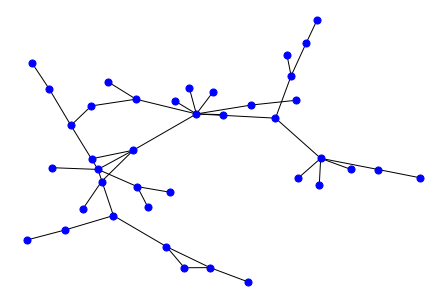

In [5]:
g_1 = get_graph_from_data_file("bio_hiv", plot=True)

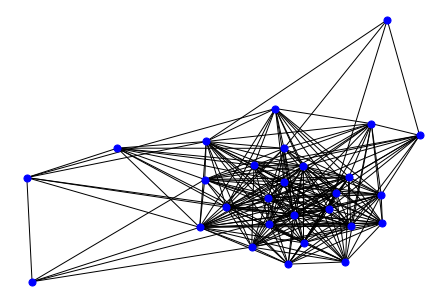

In [6]:
g_2 = get_graph_from_data_file("bio_sheep", plot=True)

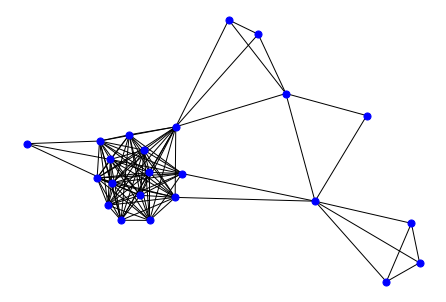

In [7]:
g_3 = get_graph_from_data_file("bio_zebra", plot=True)

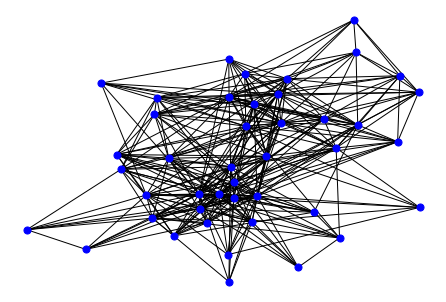

In [8]:
g_4 = get_graph_from_data_file("soc_beach", plot=True)

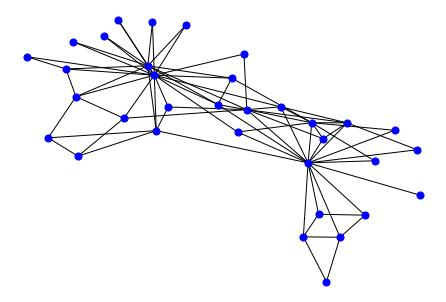

In [9]:
g_5 = get_graph_from_data_file("soc_karate", plot=True)

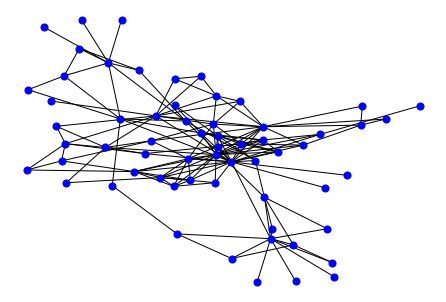

In [10]:
g_6 = get_graph_from_data_file("soc_terrorist", plot=True)

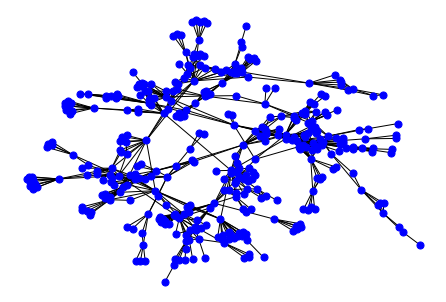

In [11]:
g_7 = get_graph_from_data_file("tec_dimacs10", plot=True)

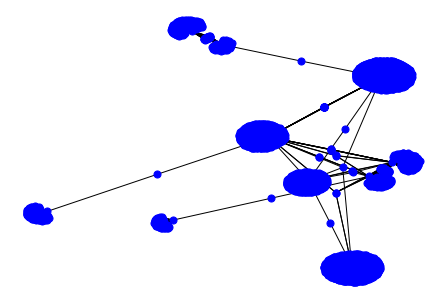

In [12]:
g_8 = get_graph_from_data_file("tec_facebook", plot=True)

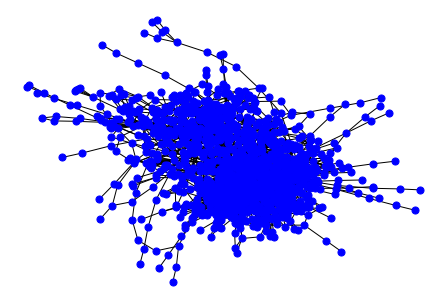

In [13]:
g_9 = get_graph_from_data_file("tec_faa", plot=True)

In [15]:
# Number of nodes:
print("Bio {} N={}".format("HIV", len(g_1)))
print("Bio {} N={}".format("Sheep", len(g_2)))
print("Bio {} N={}".format("Zebra", len(g_3)))
print("Social {} N={}".format("Windsurfers", len(g_4)))
print("Social {} N={}".format("Karate", len(g_5)))
print("Social {} N={}".format("Terrorist", len(g_6)))
print("Tec {} N={}".format("Unicode", len(g_7)))
print("Tec {} N={}".format("Facebook", len(g_8)))
print("Tec {} N={}".format("FAA", len(g_9)))

Bio HIV N=40
Bio Sheep N=28
Bio Zebra N=23
Social Windsurfers N=43
Social Karate N=34
Social Terrorist N=62
Tec Unicode N=379
Tec Facebook N=2888
Tec FAA N=1226


In [32]:
test_model(g_1, n_nets=40) #BA
test_model(g_2, n_nets=40) #BA
test_model(g_3, n_nets=40) #BA
test_model(g_4, n_nets=40) #Geometric
test_model(g_5, n_nets=40) #BA
test_model(g_6, n_nets=40) #BA
test_model(g_7, n_nets=40) #WS
test_model(g_8, n_nets=40) #BA
test_model(g_9, n_nets=40) #BA